In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input

Using TensorFlow backend.


In [2]:
top_model_weights_path = '../data/output_convnet/VGG16/VGG16_bn_model_aux.h5'

img_width = 150
img_height = 150

n_epochs = 50
batch_size = 5 # reduce to 5 in order to be able to compute the calcs

train_data_dir = "train"  
validation_data_dir = "validation"
test_data_dir = "test"

n_train_samples = 3000
n_validation_samples = 1000
n_test_samples = 1000
n_classes = 8

In [3]:
# base model
input_tensor = Input(shape=(img_width,img_height,3)) # another way to shape the input
base_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

In [4]:
# top model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(8, activation='softmax'))

In [5]:
# base model has its weights, now we load the weights on the top layer
top_model.load_weights("../data/output_convnet/VGG16/VGG16_bn_model_aux.h5")

In [6]:
# we join base and top it has to be updated to api2
model_total = Model(input= base_model.input, output= top_model(base_model.output))

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  


In [7]:
# sequential is the top layer a complex one
for i, layer in enumerate(model_total.layers):
    print (i, layer.name, layer.output_shape)

0 input_1 (None, 150, 150, 3)
1 block1_conv1 (None, 150, 150, 64)
2 block1_conv2 (None, 150, 150, 64)
3 block1_pool (None, 75, 75, 64)
4 block2_conv1 (None, 75, 75, 128)
5 block2_conv2 (None, 75, 75, 128)
6 block2_pool (None, 37, 37, 128)
7 block3_conv1 (None, 37, 37, 256)
8 block3_conv2 (None, 37, 37, 256)
9 block3_conv3 (None, 37, 37, 256)
10 block3_pool (None, 18, 18, 256)
11 block4_conv1 (None, 18, 18, 512)
12 block4_conv2 (None, 18, 18, 512)
13 block4_conv3 (None, 18, 18, 512)
14 block4_pool (None, 9, 9, 512)
15 block5_conv1 (None, 9, 9, 512)
16 block5_conv2 (None, 9, 9, 512)
17 block5_conv3 (None, 9, 9, 512)
18 block5_pool (None, 4, 4, 512)
19 sequential_1 (None, 8)


In [8]:
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_1 is freezed
layer 1, block1_conv1 is trainable
layer 2, block1_conv2 is trainable
layer 3, block1_pool is trainable
layer 4, block2_conv1 is trainable
layer 5, block2_conv2 is trainable
layer 6, block2_pool is trainable
layer 7, block3_conv1 is trainable
layer 8, block3_conv2 is trainable
layer 9, block3_conv3 is trainable
layer 10, block3_pool is trainable
layer 11, block4_conv1 is trainable
layer 12, block4_conv2 is trainable
layer 13, block4_conv3 is trainable
layer 14, block4_pool is trainable
layer 15, block5_conv1 is trainable
layer 16, block5_conv2 is trainable
layer 17, block5_conv3 is trainable
layer 18, block5_pool is trainable
layer 19, sequential_1 is trainable


In [9]:
# freezing layers implies they will not update their weights over the training
for layer in model_total.layers[:15]:
    layer.trainable = False

In [10]:
# check for updates
for i, layer in enumerate(model_total.layers):
    if layer.trainable:
        print("layer {0:d}, {1:s} is trainable".format(i, layer.name))
    else:
        print("layer {0:d}, {1:s} is freezed".format(i, layer.name))

layer 0, input_1 is freezed
layer 1, block1_conv1 is freezed
layer 2, block1_conv2 is freezed
layer 3, block1_pool is freezed
layer 4, block2_conv1 is freezed
layer 5, block2_conv2 is freezed
layer 6, block2_pool is freezed
layer 7, block3_conv1 is freezed
layer 8, block3_conv2 is freezed
layer 9, block3_conv3 is freezed
layer 10, block3_pool is freezed
layer 11, block4_conv1 is freezed
layer 12, block4_conv2 is freezed
layer 13, block4_conv3 is freezed
layer 14, block4_pool is freezed
layer 15, block5_conv1 is trainable
layer 16, block5_conv2 is trainable
layer 17, block5_conv3 is trainable
layer 18, block5_pool is trainable
layer 19, sequential_1 is trainable


In [11]:
model_total.compile(optimizer=SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# diff with bottleneck, we have to use data augmentation here
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip = True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1. / 255) # not in the val data

val_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 3000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


In [13]:
import time
# fine-tune the model

ti_ftuning = time.time()


historical_data = model_total.fit_generator(
    train_generator,
    samples_per_epoch=n_train_samples,
    epochs=n_epochs,
    verbose = 1,
    validation_data=val_generator,
    validation_steps=n_validation_samples)

tf_ftuning = time.time()
tt_ftuning = tf_ftuning - ti_ftuning

/home/jon/anaconda3/envs/test/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=50, verbose=1, validation_data=<keras.pre..., validation_steps=1000, steps_per_epoch=600)`
  del sys.path[0]


Epoch 1/50
600/600 [==============================] - 94s 156ms/step - loss: 0.6556 - acc: 0.7733 - val_loss: 0.4644 - val_acc: 0.8430
Epoch 2/50
600/600 [==============================] - 92s 153ms/step - loss: 0.5220 - acc: 0.8140 - val_loss: 0.3044 - val_acc: 0.8910
Epoch 3/50
600/600 [==============================] - 92s 154ms/step - loss: 0.4560 - acc: 0.8403 - val_loss: 0.3224 - val_acc: 0.8870
Epoch 4/50
600/600 [==============================] - 92s 153ms/step - loss: 0.4331 - acc: 0.8500 - val_loss: 0.2939 - val_acc: 0.8840
Epoch 5/50
600/600 [==============================] - 92s 154ms/step - loss: 0.4123 - acc: 0.8597 - val_loss: 0.2972 - val_acc: 0.8930
Epoch 6/50
600/600 [==============================] - 92s 153ms/step - loss: 0.3657 - acc: 0.8817 - val_loss: 0.2462 - val_acc: 0.9130
Epoch 7/50
600/600 [==============================] - 92s 154ms/step - loss: 0.3604 - acc: 0.8747 - val_loss: 0.2451 - val_acc: 0.9080
Epoch 8/50
600/600 [==============================] - 9

In [14]:
print(time.strftime("%H:%M:%S", time.gmtime(tt_ftuning)))

01:16:38


In [15]:
model_total.save_weights('../data/output_convnet/VGG16/VGG16_ft_testing_model_aux.h5') # testing
# model_total.save_weights('../data/output_convnet/VGG16/VGG16_ft_model.h5')

In [16]:
# check it out!
import math
steps = int(math.ceil(n_validation_samples / batch_size))

(loss, acc) = model_total.evaluate_generator(val_generator, steps=steps)

print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

acc: 93.00% - loss: 0.199946


In [17]:
import numpy as np

train_acc = historical_data.history['acc']
train_loss = historical_data.history['loss']

val_acc = historical_data.history['val_acc'] # validation
val_loss = historical_data.history['val_loss'] # validation

print("train acc mean: {0:.2f} * train loss mean: {1:.2f}".format(np.average(train_acc),np.average(train_loss)))
print("validation acc mean: {0:.2f} * validation loss mean: {1:.2f}".format(np.average(val_acc),np.average(val_loss)))

train acc mean: 0.90 * train loss mean: 0.28
validation acc mean: 0.92 * validation loss mean: 0.24


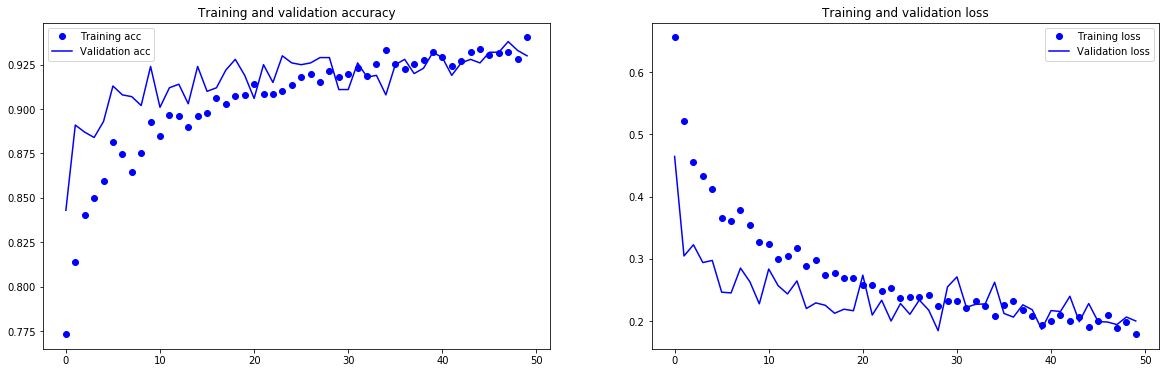

In [19]:
# historical_data.history acc and loss data over the epochs (train and validation)
import matplotlib.pyplot as plt
import os

PATH_TO_DF = "../data/output_convnet/VGG16"

range_epochs = range(n_epochs)

fig = plt.figure(figsize=(20, 6))

fig.add_subplot(1,2,1)
plt.plot(range_epochs, train_acc, 'bo', label='Training acc')
plt.plot(range_epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1,2,2)
plt.plot(range_epochs, train_loss, 'bo', label='Training loss')
plt.plot(range_epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig(os.path.join(PATH_TO_DF, "VGG16_ft_acc_loss_aux.png"), bbox_inches='tight')
# plt.savefig(os.path.join(PATH_TO_DF, "VGG16_ft_acc_loss.png"), bbox_inches='tight')
plt.show()

next cell is used to load the training weigths, in case you have a better GPU they can be ignored

In [20]:
test_convnet = ImageDataGenerator(rescale=1. / 255)

test_generator = test_convnet.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle =False,
    class_mode='categorical')

Found 1000 images belonging to 8 classes.


In [21]:
steps = int(math.ceil(n_test_samples / batch_size))

(loss, acc) = model_total.evaluate_generator(test_generator, steps=steps)

print("acc: {0:.2f}% - loss: {1:f}".format(acc * 100, loss))

acc: 91.10% - loss: 0.261231


In [22]:
predictions = model_total.predict_generator(test_generator, steps = steps)

In [23]:
from sklearn.metrics import confusion_matrix

PATH_TO_IMG = "../data/input_dataset"

prediction_list = []
real_label_list = []

cat_dict = test_generator.class_indices # the key attribute
inverse_coding = {value: key for key, value in cat_dict.items()} # dict of categories

for label in test_generator.classes:
    real_label_list.append(inverse_coding[label])
    
for prediction in predictions:
    prediction_list.append(inverse_coding[np.argmax(prediction)])

# in order to get the confusion matrix
class_names = sorted([folder for folder in os.listdir(PATH_TO_IMG)
                  if os.path.isdir(os.path.join(PATH_TO_IMG, folder))])
prediction_list_arr = np.array(prediction_list) 
real_label_list_arr = np.array(real_label_list)

VGG16_cm_ft = confusion_matrix(real_label_list_arr,prediction_list_arr)

In [24]:
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)

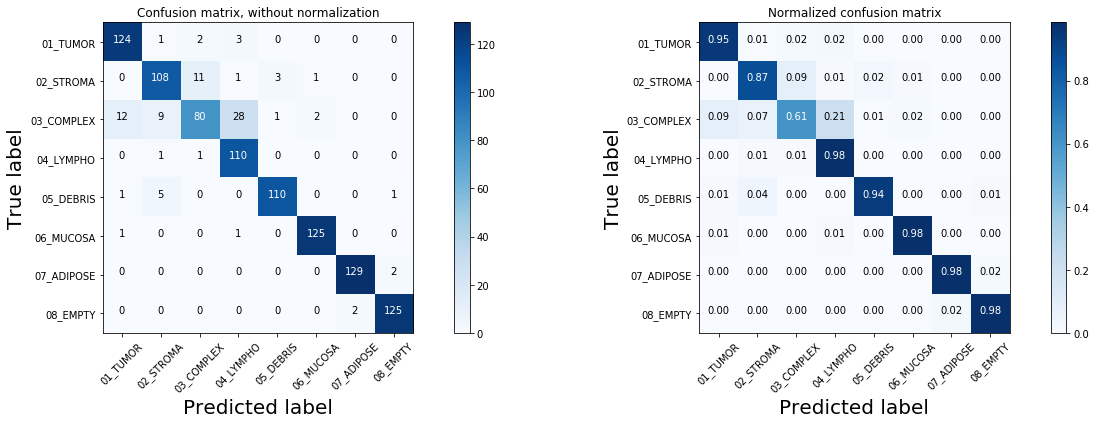

In [25]:
fig = plt.figure(figsize=(20, 6))


fig.add_subplot(1,2,1)
plot_confusion_matrix(VGG16_cm_ft, classes=class_names,
                      title='Confusion matrix, without normalization')

fig.add_subplot(1,2,2)
plot_confusion_matrix(VGG16_cm_ft, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.savefig(os.path.join(PATH_TO_DF, "VGG16_ft_test.png"), bbox_inches='tight') # png 70kb vs jpg 135 kb

plt.show()